<center><h1>Create a Random Forest Classifier Using scikit-learn</h1></center>

|![Sparky](sparky.png)|![Penny](penny.png)|
|:-------------------:|:-------------------:|
|Sparky the Dog|Penny the Cat|

<center><h2>Are You Likely to Be a Dog Person or a Cat Person?</h2></center>

# Introduction

In this lab, we take a quick look at __scikit-learn__, a machine learning framework.

Designed to be native to Python, scikit-learn contains various classification, regression, and clustering algorithms, including __random forests__ which we use in this lab.

# Scenario

You run a local pet store, and you want to know what kind of products to recommend to new customers. You've contracted a survey company to collect information on 199 of your current customers, including if they think themselves to be 'dog people' or 'cat people'. The questions the survey asked were:

- Do you like walking?
- Do you like running?
- What is your favorite color?
- How many miles do you walk in a day?
- Do you like dogs or cats?

Clearly this is a fictitious dataset. If this were real, you'd fire the survey company!

We're going to use a random forest algorithm trained with our survey data to build a model that classifies new customers as dog or cat people.

We do this using standard Python libraries such as NumPy, Pandas, and matplotlib along with scikit-learn.

## scikit-learn
### Machine Learning in Python

- Simple and efficient tools for data mining and data analysis.
- Accessible to everybody and reusable in various contexts.
- Built on NumPy, SciPy, and matplotlib.
- Open source and commercially usable - BSD license.

_(Source: https://scikit-learn.org/)_

# How to Use This Lab

All of the code is provided for you in this lab as our solution to the tasks presented. You could simply execute the notebook to get a result, but that's not really very hands-on and it won't teach you anything but how to execute cells in a Jupyter notebook. To get the most from this lab, you should understand what the code in each cell is trying to accomplish, and then take the time to experiment: make changes, break it, fix it, and learn! You can always pull the code down again to get a clean copy.

# 1)  Import Libraries

In [46]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
#Use a magic command to display the graphs better
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

# Set the random seed to have reproducible results
np.random.seed(42)

# These two includes help us render a graph
from IPython.display import Image

# 2) Prepare the Data

We have a dataset created from a set of people who either liked dogs or cats. Clearly this is a fictional dataset and some of the data is useless. But let's see what we can learn from it.

First we load the data. Pandas provides a very convenient way of loading CSV data, which is what our survey results are stored as.

In [2]:
df = pd.read_csv("data.csv")

In [3]:
df.head(10)

,walking,running,color,distance_walked,dogs_cats
0,1,1,red,1,1
1,1,1,blue,2,1
2,1,1,green,3,1
3,1,1,blue,4,1
4,1,1,blue,5,1
5,1,1,red,6,1
6,1,1,green,7,1
7,1,1,green,8,1
8,1,1,blue,9,1
9,1,1,red,1,1


Let's check to see what data types we have.

In [4]:
df.dtypes

walking             int64
running             int64
color              object
distance_walked     int64
dogs_cats           int64
dtype: object

For our first data preparation, let's change the names of some of the columns, including marking ```dogs_cats``` as an out label.

In [5]:
df.columns = ['walk', 'run', 'color', 'distance', 'label']

The data is not shuffled very well. We see a lot of similar information, so we didn't learn much. We don't want to look at the rest of our data individually to improve our understanding. Rather, we want to describe the data as a whole. Let's have Pandas tell us more about the data statistically.

In [6]:
df.describe()

,walk,run,distance,label
count,199.000000,199.000000,199.000000,199.000000
mean,0.497487,0.497487,4.979899,0.321608
std,0.501255,0.501255,2.597512,0.468272
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,3.000000,0.000000
50%,0.000000,0.000000,5.000000,0.000000
75%,1.000000,1.000000,7.000000,1.000000
max,1.000000,1.000000,9.000000,1.000000


For our next data preparation step, let's format the data in the columns so the model will understand it better. 

Despite the `walk`, `run`, and `label` columns being integers, they are actually representing a binary value, 1 or 0. For `walk` and `run`, this corresponds to True or False for liking that activity. For `label`, this represents whether you prefer cats or dogs. Instead of using integers, let's change these fields to the boolean data type.

`color_type` is not random text. It actually represents one of three categories (red, green, or blue). Instead of treating it as text, let's change it to a categorical data type.

Note that we are not modifying distance. The question value it represents asks for a number, and it currently is a number. No change needed!

In [7]:
df['walk'] = df['walk'].astype('bool')
df['run'] = df['run'].astype('bool')
color_type = CategoricalDtype(categories=['red', 'green', 'blue'])
df['color'] = df['color'].astype(color_type)
df['label'] = df['label'].astype('bool')

In [8]:
df.dtypes

walk            bool
run             bool
color       category
distance       int64
label           bool
dtype: object

The algorithm will not understand color as a list of strings. With the data as it is now, we can expect to get the following error when we trt to fit the data:
`ValueError: could not convert string to float: 'green'`
So we use the `get_dummies` command to perform a one hot encoding process directly into the dataframe.

In [9]:
df = pd.get_dummies(df, prefix=['color'])

With data formatting complete, let's take a quick look at what our data looks like now.

In [10]:
df.head(10)

,walk,run,distance,label,color_red,color_green,color_blue
0,True,True,1,True,1,0,0
1,True,True,2,True,0,0,1
2,True,True,3,True,0,1,0
3,True,True,4,True,0,0,1
4,True,True,5,True,0,0,1
5,True,True,6,True,1,0,0
6,True,True,7,True,0,1,0
7,True,True,8,True,0,1,0
8,True,True,9,True,0,0,1
9,True,True,1,True,1,0,0


<a id='section3'></a>

The last data preparation task is to split the data into training and testing sets. We use scikit-learn's `train_test_split` to split off 20% of the data for testing so we have 80% for training. We also set `random_state` so that we'll have a random, but repeatable, data split.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', 1), df['label'], test_size = .2, random_state=10)

/tmp/ipykernel_2207/2310627642.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train, X_test, y_train, y_test = train_test_split(df.drop('label', 1), df['label'], test_size = .2, random_state=10)


# 3) Create the Model

The time has come to create the model. We're going to create a `RandomForestClassifier` moodel. We set one parameter, but there are many more options for tweaking your model. You can read about them in the [Random Forest Classifier documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [12]:
model = RandomForestClassifier(max_depth=5)

Now we `fit` the model on the training data.

In [13]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

With 199 survey responses, this trains very quickly. Now, let's see what we got.

# 4) Evaluate the Model

First, we grab the estimator from the trained model.

In [14]:
estimator = model.estimators_[0]
feature_names = [i for i in X_train.columns]

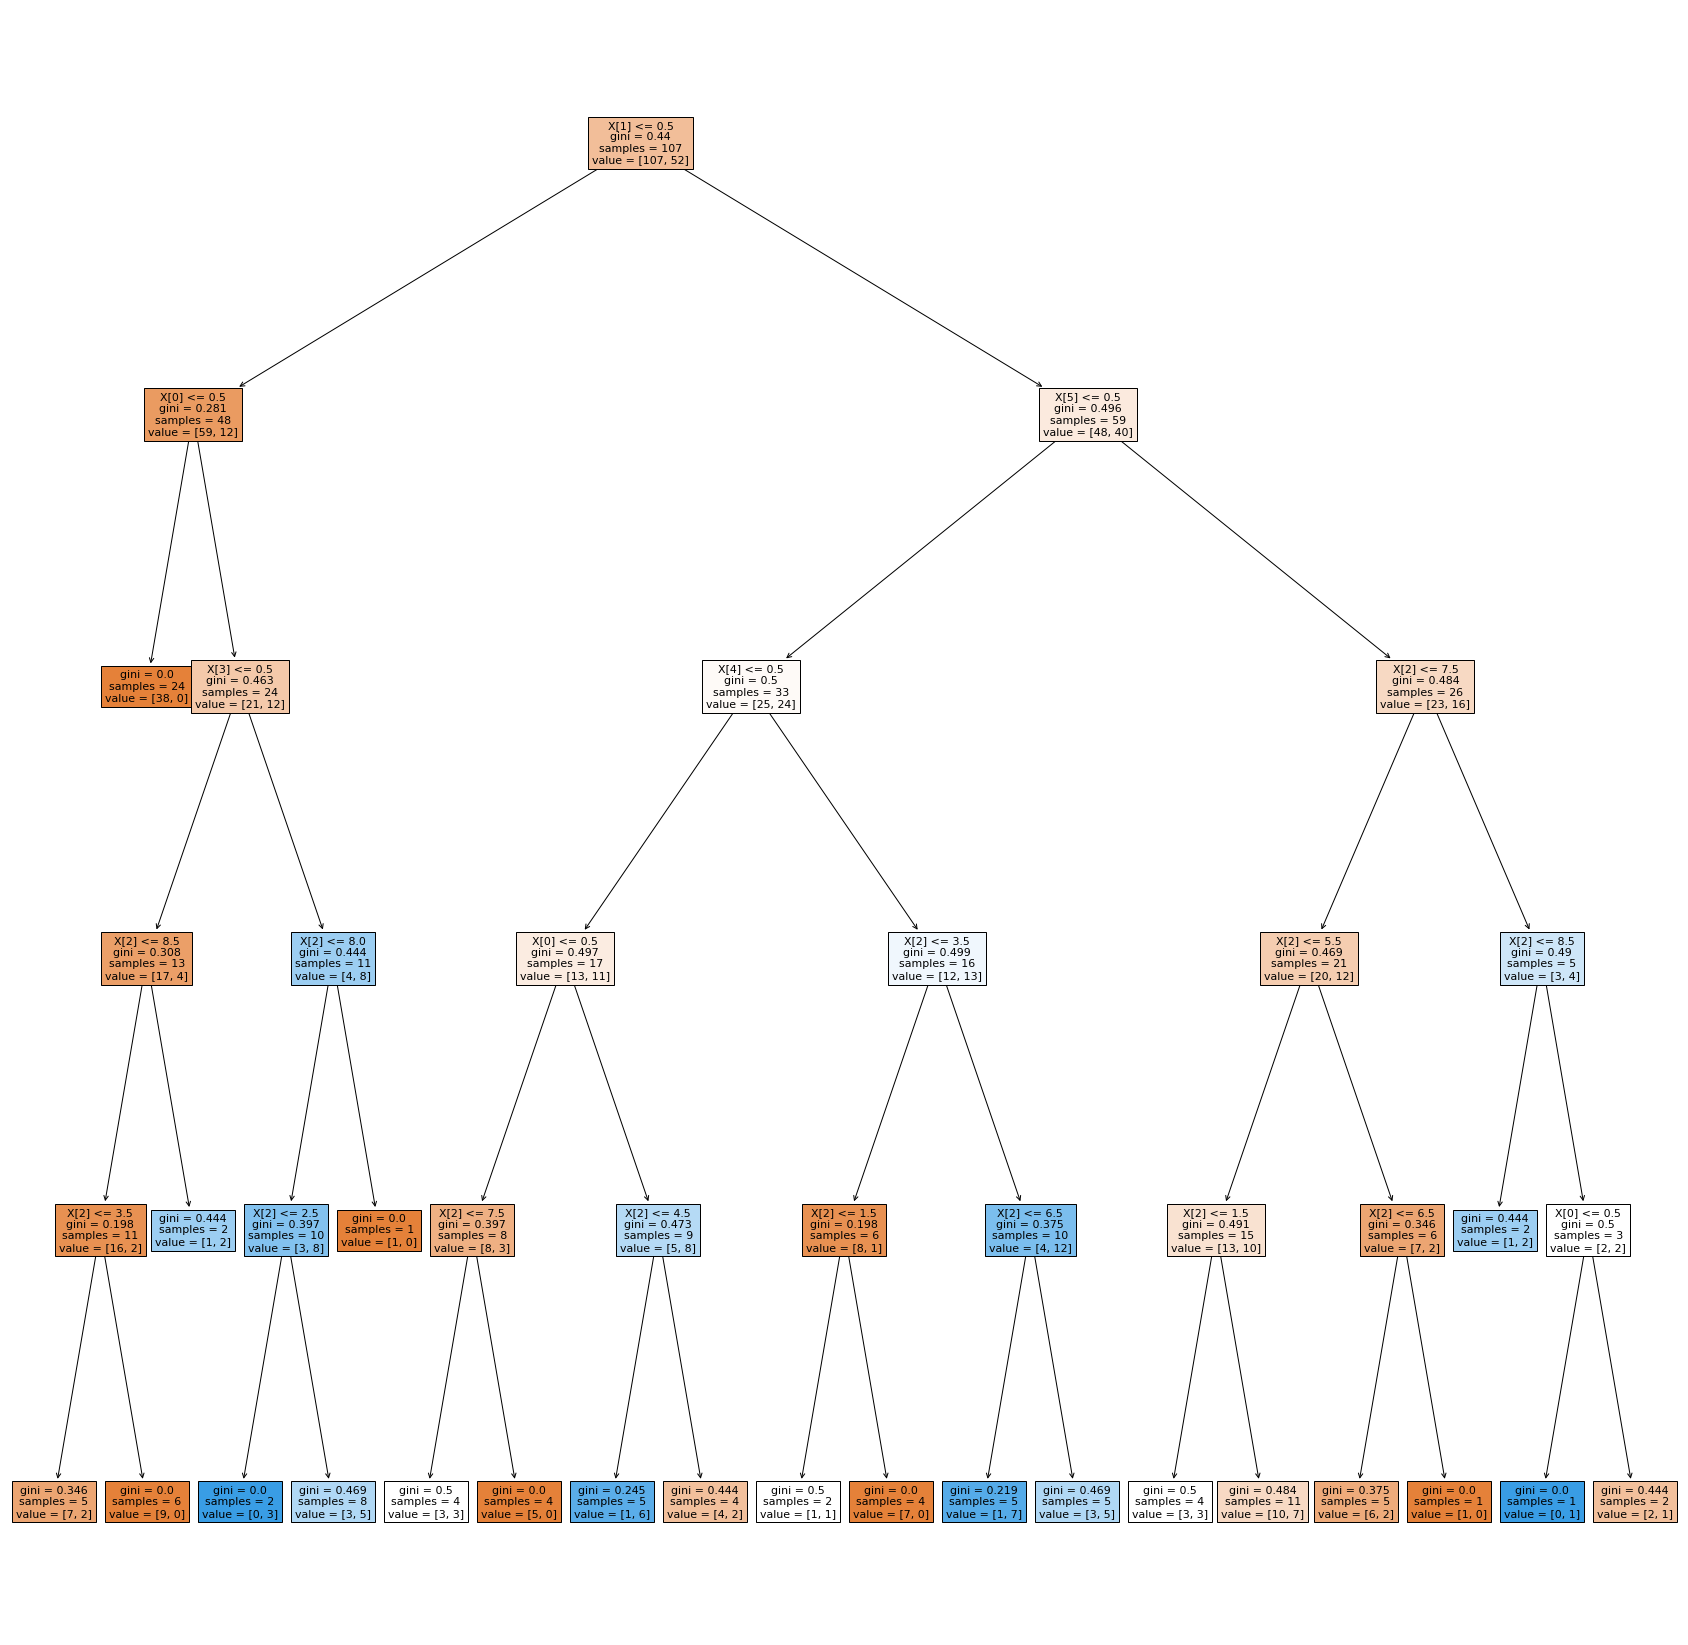

In [51]:
_, ax = plt.subplots(figsize=(30,30)) # Resize figure
plot_tree(estimator, filled=True, ax=ax, fontsize=11)
plt.show()

Now let's run our testing data through the model.

In [52]:
y_predict = model.predict(X_test)

To see how it performed, let's use ```confusion_matrix``` to create a confusion matrix for the test data predictions.

In [53]:
conf_matrix = confusion_matrix(y_test, y_predict)
conf_matrix

array([[23,  3],
       [10,  4]])

That's not very easy to read. Let's add some style to it using the `seaborn` library.

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Actual', ylabel='Predicted'>

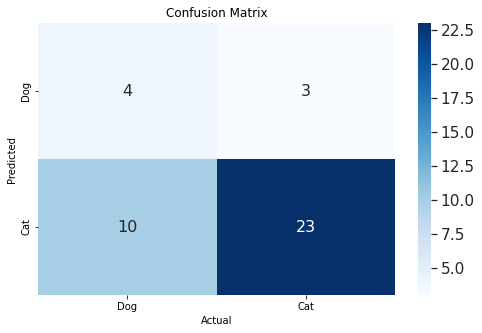

In [54]:
tn, fp, fn, tp = conf_matrix.ravel()
cleaned_conf_matrix = np.array([[tp, fp], [fn, tn]])
y_true = ["Dog", "Cat"]
df_cm = pd.DataFrame(cleaned_conf_matrix, columns=y_true, index=y_true)
df_cm.index.name = 'Predicted'
df_cm.columns.name = 'Actual'

df_cm.dtypes

plt.figure(figsize = (8,5))
plt.title('Confusion Matrix')
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})# font size

And from the confusion matrix, let's calculate **sensitivity** and **specificity**.

In [55]:
sensitivity = tp / (tp + fn)
print('Sensitivity : ', sensitivity )

specificity = tn / (tn + fp)
print('Specificity : ', specificity)

Sensitivity :  0.2857142857142857
Specificity :  0.8846153846153846


Now let's look at the __ROC__ graph.

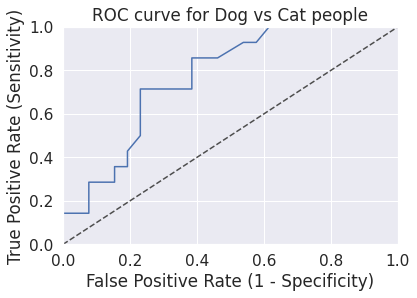

In [56]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Dog vs Cat people')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

And calculate the __AUC__. Quick quiz: what does AUC stand for?

In [57]:
auc(fpr, tpr)

0.7664835164835165

# 5) Predict for yourself!

Change the values for the survey questions below and see what the model predicts for you!

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


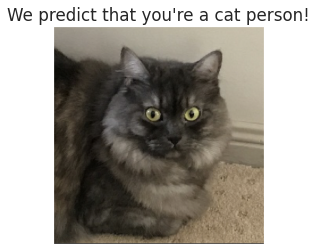

In [58]:
# Do you like walking?  1=yes, 0=no
like_walking = 0

# Do you like running?  1=yes, 0=no
like_running = 1

# How far do you walk in a day?
distance = 10

# What is your favorite color? Answer ONLY ONE with a 1
red = 0
green = 1
blue = 0

# Get the prediction:
prediction = model.predict([[like_walking, like_running, distance, red, green, blue]])

# The following is all display code:
if prediction[0]:
    animal = 'dog'
    pic = 'sparky.png'
else:
    animal = 'cat'
    pic = 'penny.png'
    
img=mpimg.imread(pic)
imgplot = plt.imshow(img)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.title("We predict that you're a %s person!" % animal)
plt.show()


# Conclusion
Did it get the answer right for you? Probably not, but the data the model is trained from is essentially random, so the results are as well. The Random Forest algorithm did its best to find a pattern and split the data along the nodes, but it's trying to find a signal in data that is only noise.

In this lab, we've demonstrated how you can turn survey data into predictions using scikit-learn. Using real data from a properly designed survey, you can very quickly get pretty good results.

Go ahead. Try a few more predictions for fun. You know you want to!